In [66]:
import pandas as pd

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (1460, 81)
Test shape: (1459, 80)


In [67]:
# Check duplicates
print("Duplicate rows in train:", train.duplicated().sum())
print("Duplicate rows in test:", test.duplicated().sum())

# Drop duplicates if any
train = train.drop_duplicates()
test = test.drop_duplicates()

Duplicate rows in train: 0
Duplicate rows in test: 0


In [69]:
# Missing values in train
missing_train = train.isnull().sum()
missing_train = missing_train[missing_train > 0].sort_values(ascending=False)
print("Missing values in train:\n", missing_train)

# Missing values in test
missing_test = test.isnull().sum()
missing_test = missing_test[missing_test > 0].sort_values(ascending=False)
print("\nMissing values in test:\n", missing_test)

Missing values in train:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

Missing values in test:
 PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
MasVnrType       894
FireplaceQu      730
LotFrontage      227
GarageQual        78
GarageCond        78
GarageYrBlt       78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrArea        15
MSZoning           4
Functional         2
BsmtFullBath       2
Utilities          2
BsmtHalfBath       2
Exterior1st        1
Exterior2nd        1
TotalBsmtSF

In [70]:
# Columns with extremely high missing values
high_na_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence']

for col in high_na_cols:
    train[col] = train[col].fillna('None')
    test[col] = test[col].fillna('None')

In [71]:
cat_na_cols = ['MasVnrType','BsmtQual','BsmtCond','BsmtExposure','FireplaceQu',
               'GarageType','GarageFinish','GarageQual','GarageCond','BsmtFinType1','BsmtFinType2']

for col in cat_na_cols:
    train[col] = train[col].fillna('None')
    test[col] = test[col].fillna('None')

In [72]:
num_na_cols = ['LotFrontage','GarageYrBlt','MasVnrArea']

for col in num_na_cols:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(test[col].median())

In [73]:
small_na_cols = ['MSZoning','Functional','Utilities','BsmtFullBath','BsmtHalfBath',
                 'KitchenQual','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','GarageCars',
                 'GarageArea','Exterior1st','Exterior2nd','SaleType','Electrical']

for col in small_na_cols:
    train[col] = train[col].fillna(train[col].mode()[0])
    test[col] = test[col].fillna(test[col].mode()[0])

In [27]:
print("Remaining missing values in train:", train.isnull().sum().sum())
print("Remaining missing values in test:", test.isnull().sum().sum())

Remaining missing values in train: 0
Remaining missing values in test: 1


In [76]:
# Identify which column still has missing value
missing_test_col = test.columns[test.isnull().any()]
print("Column with remaining missing value in test:", missing_test_col)

# Fill it with mode (most common value) or a safe default
for col in missing_test_col:
    test[col] = test[col].fillna(test[col].mode()[0])

# Verify again
print("Remaining missing values in test after fixing:", test.isnull().sum().sum())

Column with remaining missing value in test: Index([], dtype='object')
Remaining missing values in test after fixing: 0


In [74]:
# Function to detect outliers
def detect_outliers(df, cols):
    outlier_summary = {}
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5*IQR
        upper_bound = Q3 + 1.5*IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        outlier_summary[col] = len(outliers)
    return outlier_summary

numeric_cols = train.select_dtypes(include=['int64','float64']).columns.tolist()
numeric_cols.remove('SalePrice')  # exclude target

outlier_counts = detect_outliers(train, numeric_cols)
outlier_counts = {k:v for k,v in outlier_counts.items() if v>0}  # only columns with outliers

# Display
outlier_counts


{'MSSubClass': 103,
 'LotFrontage': 106,
 'LotArea': 69,
 'OverallQual': 2,
 'OverallCond': 125,
 'YearBuilt': 7,
 'MasVnrArea': 98,
 'BsmtFinSF1': 7,
 'BsmtFinSF2': 167,
 'BsmtUnfSF': 29,
 'TotalBsmtSF': 61,
 '1stFlrSF': 20,
 '2ndFlrSF': 2,
 'LowQualFinSF': 26,
 'GrLivArea': 31,
 'BsmtFullBath': 1,
 'BsmtHalfBath': 82,
 'BedroomAbvGr': 35,
 'KitchenAbvGr': 68,
 'TotRmsAbvGrd': 30,
 'Fireplaces': 5,
 'GarageYrBlt': 1,
 'GarageCars': 5,
 'GarageArea': 21,
 'WoodDeckSF': 32,
 'OpenPorchSF': 77,
 'EnclosedPorch': 208,
 '3SsnPorch': 24,
 'ScreenPorch': 116,
 'PoolArea': 7,
 'MiscVal': 52}

In [77]:
# Remove extreme GrLivArea and TotalBsmtSF
train = train[train['GrLivArea'] < 4500]
train = train[train['TotalBsmtSF'] < 3000]

# Optional: Remove extreme LotArea
train = train[train['LotArea'] < 200000]

# Optional: Remove extreme EnclosedPorch, OpenPorchSF, ScreenPorch (very rare)
train = train[train['EnclosedPorch'] < 350]
train = train[train['OpenPorchSF'] < 300]
train = train[train['ScreenPorch'] < 300]

In [78]:
# Check dataset shape after removing outliers
train.shape

(1436, 81)

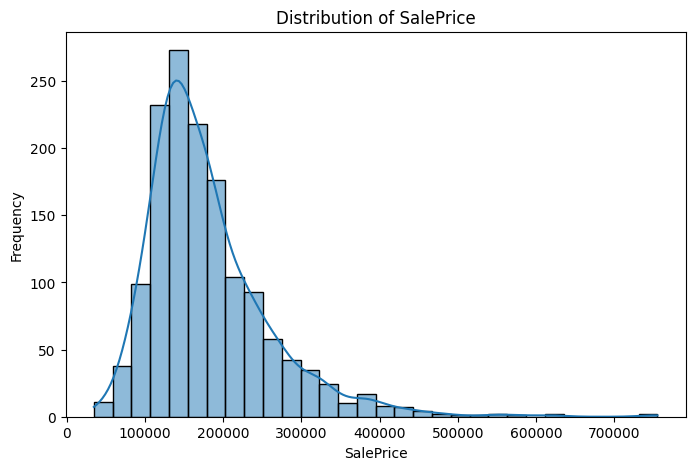

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(y_train, kde=True, bins=30)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

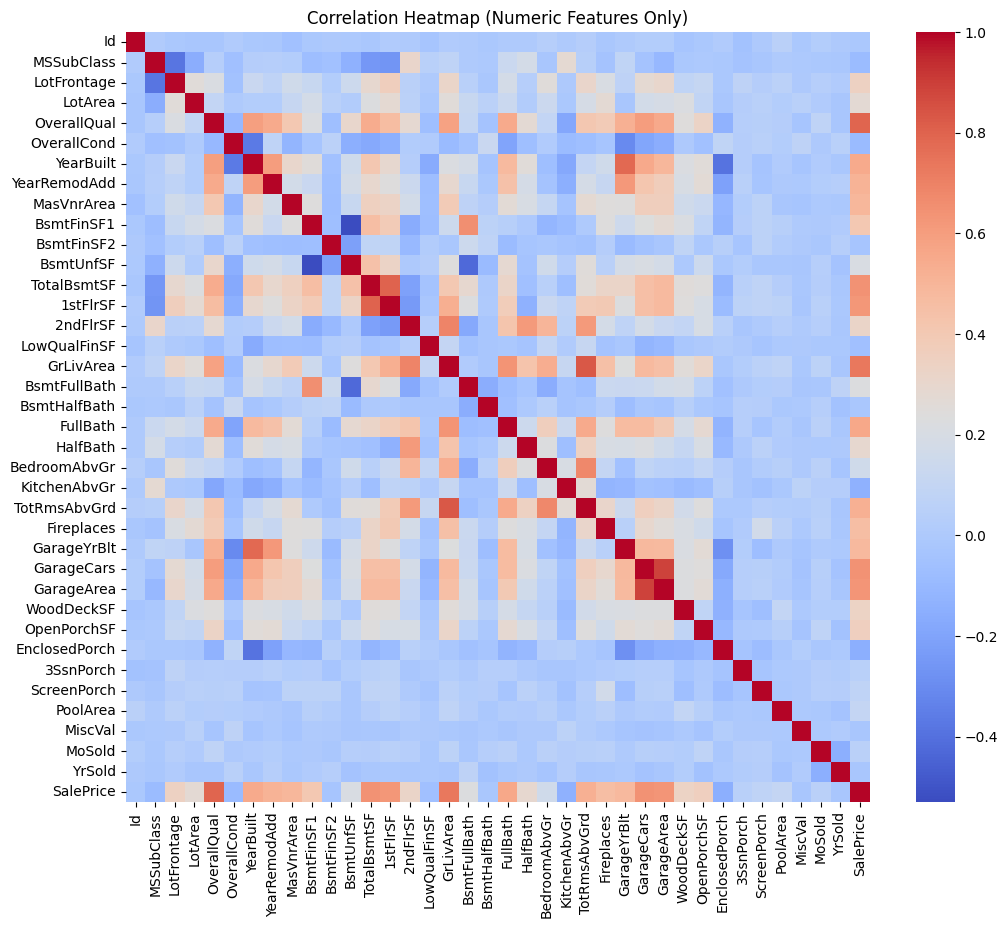

In [79]:
# Select only numeric columns
numeric_train = train.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(12,10))
corr_matrix = numeric_train.corr()
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()

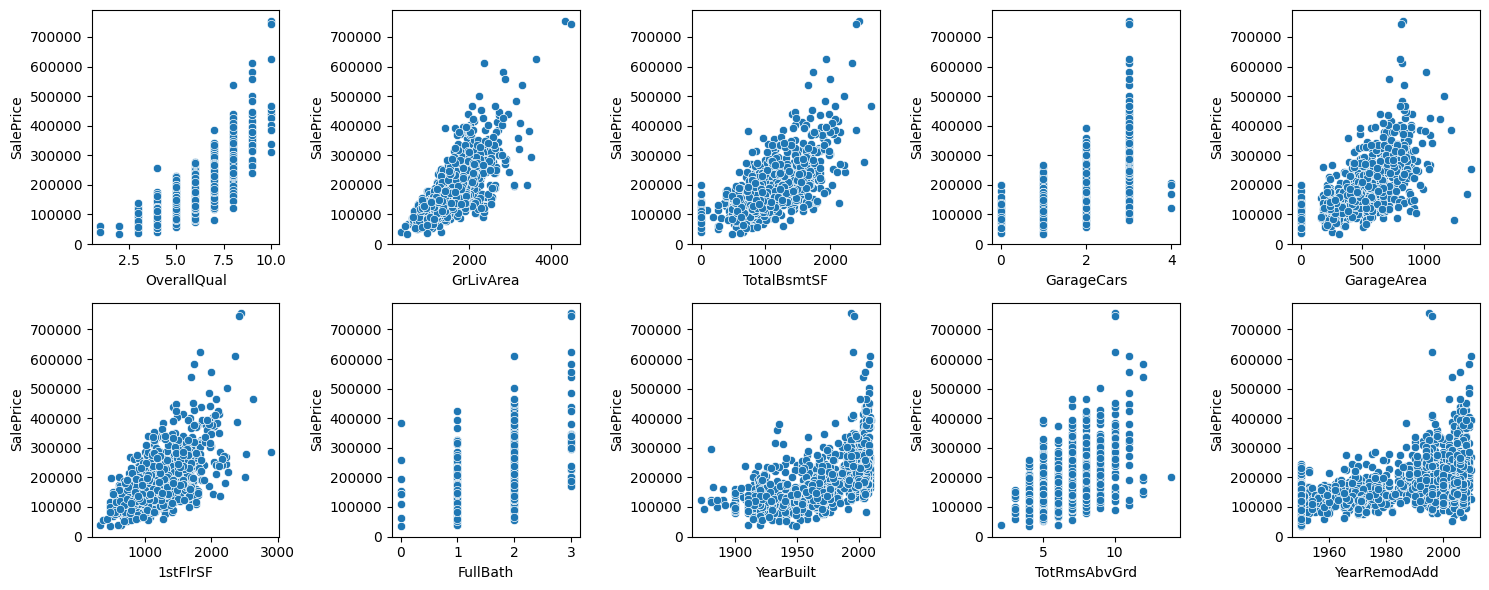

In [80]:
# Find top correlated features with SalePrice
top_features = corr_matrix['SalePrice'].sort_values(ascending=False).head(11).index[1:]

plt.figure(figsize=(15,6))
for i, col in enumerate(top_features, 1):
    plt.subplot(2, 5, i)
    sns.scatterplot(x=train[col], y=y_train)
    plt.xlabel(col)
    plt.ylabel("SalePrice")
plt.tight_layout()
plt.show()

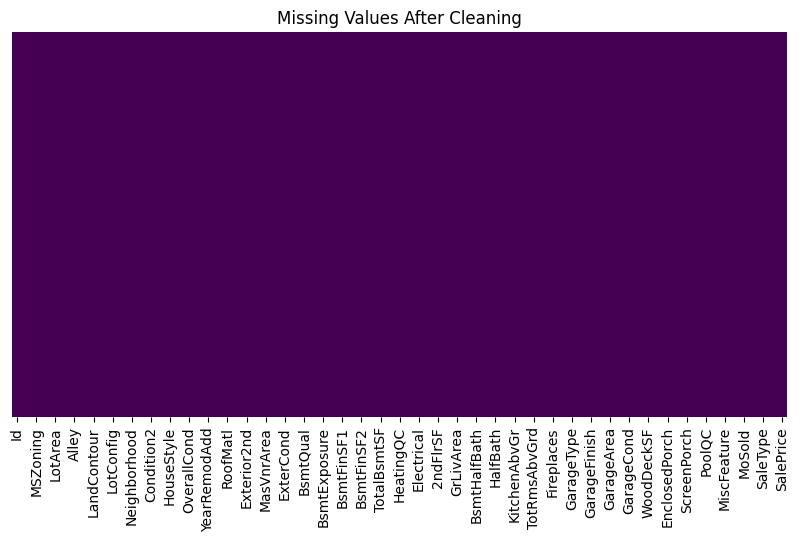

In [81]:
plt.figure(figsize=(10,5))
sns.heatmap(train.isnull(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("Missing Values After Cleaning")
plt.show()

In [82]:
# Save cleaned train dataset
train.to_csv("train_cleaned_final.csv", index=False)

# Save test dataset (already cleaned)
test.to_csv("test_cleaned_final.csv", index=False)

print("✅ Cleaned datasets saved successfully!")

✅ Cleaned datasets saved successfully!


In [83]:
import numpy as np

# Log-transform target
train['SalePrice'] = np.log1p(train['SalePrice'])

# List of skewed numeric features to log-transform
skewed_features = ['GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'LotArea']

for col in skewed_features:
    train[col] = np.log1p(train[col])
    test[col] = np.log1p(test[col])


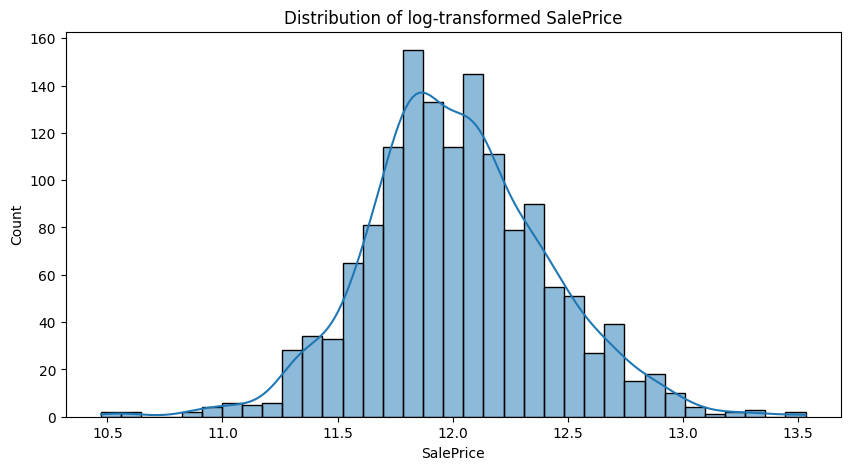

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(train['SalePrice'], kde=True)
plt.title("Distribution of log-transformed SalePrice")
plt.show()

In [87]:
import pandas as pd
import numpy as np

# Load cleaned datasets
train = pd.read_csv("train_cleaned_final.csv")
test = pd.read_csv("test_cleaned_final.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (1436, 81)
Test shape: (1459, 80)
